# 7.2: Examining `G.fst` with `openFST` 
## (in `python` with `pywrapfst`)

`openFST` has a `python` wrapper called [`pywrapfst`](http://www.openfst.org/twiki/bin/view/FST/PythonExtension) that gives us *most* of the functionality of `openFST` but from inside `python`.

We will also use some custom methods that are in `utils/fst_manipulate/fst_manipulate.py`.

In [1]:
# because of the way `kaldi` installed `openFST` we have to add the path to the python functions here
import sys
sys.path.append("/scratch/kaldi/tools/openfst-1.6.2/lib/python2.7/site-packages")    

from utils.fst_manipulate import fst_manipulate as fstman  # scripts to further manipulate fsts

import pywrapfst as openfst  # the wrapper module
import graphviz as dot   # a wrapper for graphviz, which will allow us to visualize

## read in the `fst`

Using `Fst.read()` we can load the `fst` into an easy-to-read format with the following structure:

 - TODO

In [2]:
fst_in = openfst.Fst.read("resource_files/fst/animal_fst-2_gram.fst")
print(fst_in)

3	2	<s>	0
0	1	</s>	2.95194
0	4	the	1.34249
0	5	mouse	3.10607
0	6	ate	2.18979
0	7	cheese	3.10607
0	8	cat	2.95194
0	9	and	2.49994
0	10	dog	2.95194
0	11	lion	2.95194
0	12	tyrannosaurus	3.10607
0	13	rex	3.10607
0	14	human	4.20468
0	15	shot	4.20468
0	16	<unk>	2.18979
1	0
2	0	<eps>	1.60944
2	4	the	0.427346
4	0	<eps>	1.76766
4	5	mouse	2.04333
4	7	cheese	2.04333
4	8	cat	1.86265
4	10	dog	1.86265
4	11	lion	1.86265
4	12	tyrannosaurus	2.04333
4	14	human	3.61421
5	0	<eps>	0.810931
5	1	</s>	2.00747
5	4	the	1.48194
5	6	ate	1.82721
5	9	and	1.35206
6	0	<eps>	2.70805
6	4	the	0.0505077
7	0	<eps>	1.25276
7	1	</s>	1.84654
7	9	and	0.519392
8	0	<eps>	0.916291
8	1	</s>	2.11283
8	4	the	1.5873
8	6	ate	1.40741
8	9	and	1.45742
9	0	<eps>	2.39789
9	4	the	0.0695268
10	0	<eps>	0.916291
10	1	</s>	2.11283
10	4	the	1.5873
10	6	ate	1.06486
10	9	and	2.01864
11	0	<eps>	1.09861
11	1	</s>	2.05164
11	6	ate	0.730316
11	9	and	1.97707
12	0	<eps>	1.79176
12	13	rex	0.173406
13	0	<eps>	1.25276
13	1	</s>	1.84654
13	6	ate	0.505155
14

## write to `.dot`

We can then write this `fst` into a `.dot` (from `graphviz`) format

In [3]:
fst_in.draw("resource_files/fst/animal_fst-2_gram.dot")

Unfortunately, the default setting is to write the `.dot` so that the image is in `landscape` format.

In [4]:
%%bash
head resource_files/fst/animal_fst-2_gram.dot

digraph FST {
rankdir = LR;
size = "8.5,11";
label = "";
center = 1;
orientation = Landscape;
ranksep = "0.4";
nodesep = "0.25";
3 [label = "3", shape = circle, style = bold, fontsize = 14]
	3 -> 2 [label = "<s>:<s>", fontsize = 14];


This doesn't visualize well in these notebooks, so the `python` method below will *wrap* both the `FST.draw()` command along with an in-place edit of the `.dot` file to `orientation = Portrait`.

In [5]:
fstman.write_wrapper(fst_in, "resource_files/fst/animal_fst-2_gram.dot")    

## visualize `fst`

Then we can visualize the `.dot` version of our `fst` using `graphviz`.

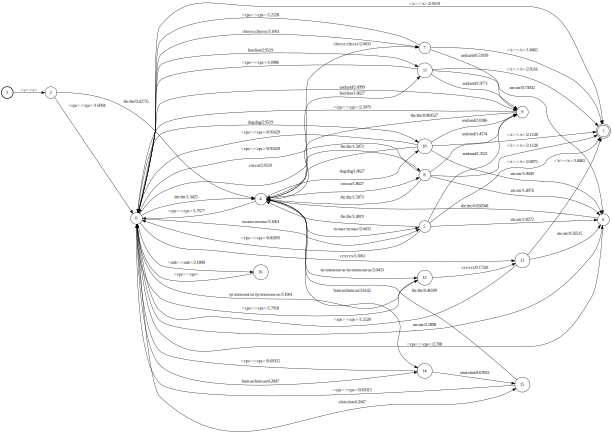

In [6]:
dot.Source.from_file("resource_files/fst/animal_fst-2_gram.dot")

**Note:** You may prefer to render the `.dot` in your browser using a site like http://www.webgraphviz.com/.  Just copy the `.dot` text from `resource_files/fst/animal_fst-2_gram.dot`.

## analyzing the `fst`


Now that we've generated an `fst` to represent our language model, let's look at what's happening.

### `probability` values in `fst` v. equivalent values in language model

The first thing to notice is that the `fst` uses `negative` `log, base e` values whereas our original `ARPA` language model used `log, base 10` values.  You can **roughly** convert the values from the `fst` to the values in the language model with the following:

$language\_model\_value = -(fst\_value / 2.303)$

## checking to see if sequence is valid according to language model

Ultimately, we will use an `FST` to determine the most likely transcription of the audio sent as input to our `ASR` pipeline.  For now, we can use the `FST` representing our language model to see how we would need to travel through the `FST` in order to reprent any sequence.

In [7]:
sample_sentence = "the rex ate the human"

`fst_manipulate.py` has a method called `sequence_to_fst()` which will convert any sequence represented as a `<str>` into a "mini"-`FST`.

It takes two arguments:
 - `seq_string` --> the `<str>` of the sequence we want to learn about
 - `lm_fst` --> the `FST` representing our language model; we need this to ensure we correctly map words to indices
 
It will generate a very basic `FST` representing the sequence.

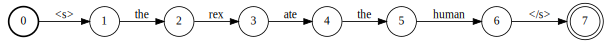

In [18]:
sample_sentence_fst = fstman.sequence_to_fst(
    seq_string=sample_sentence,    
    lm_fst=fst_in                  
)                                 
sample_sentence_fst

We can then [`compose`](http://www.openfst.org/twiki/bin/view/FST/ComposeDoc) a new `FST` which is a combination of our original `FST` (representing our language model) and our "mini"-`FST` (representing our sequence we want to learn about).  

If the sequence we provide **can** be modeled by our language model, then we should get out a resulting `FST`.  And if this `compose` step fails, we know that our language model is incapable of modeling that sequence.

**Note:** Because we have a token representing `<unk>`, we will be able to model any sequence by our language model.

`fst_manipulate.py` has a method called `check_sequence()` which does two things:
 1. calls `sequence_to_fst()` to build the "mini"-`FST`
 2. calls `compose` to build the composed `FST`.

In [9]:
sample_sentence_fst_out = fstman.check_sequence(sample_sentence, fst_in)
sample_sentence_fst_out

We can now see, essentially, just the portion of the language model that we need in order to model our sequence.

**Note**: **TODO** explain top and bottom path

Unfortunately if we want to know how likely the sequence is, we can no longer use `pywrapfst`.  But `openfst` from the command line does give us a "roundabout" way of doing it.  But first we have to write our composed `FST` to binary file, so that `openfst` can use it. 

In [10]:
sample_sentence_fst_out.write("resource_files/fst/sample_sentence.fst")

Then we will extract the information we want from `fstshortestdistance`.  This gives us the shortest distance from the `start` to any node in an `FST`.  

In [23]:
%%bash
. path.sh   # we have to source this file so we don't have to use full paths
fstshortestdistance --help | head -n15

Finds shortest distance(s) in an FST.

  Usage: fstshortestdistance [in.fst [distance.txt]]

PROGRAM FLAGS:

  --delta: type = double, default = 0.000976562
  Comparison/quantization delta
  --nstate: type = int64, default = -1
  State number threshold
  --queue_type: type = string, default = "auto"
  Queue type: one of: "auto", "fifo", "lifo", "shortest", "state", "top"
  --reverse: type = bool, default = false
  Perform in the reverse direction



In our case, we just want to know the distance (or "cost") from the `start` to the `final` node in our composed `FST`. 

In [20]:
%%bash
. path.sh
fstshortestdistance resource_files/fst/sample_sentence.fst

0	0
1	0
2	1.60943794
3	0.427345991
4	2.19500828
5	5.3010807
6	6.5538435
7	5.80623579
8	8.51428318
9	5.85674334
10	7.62440586
11	9.47095013
12	10.1640978
13	13.1160345


TODO continue

### TODO use PyNLPl to double check scores